## Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim of this data science project is to build a predictive model and find out the sales of each product at a particular store.

## Loading Packages and Data

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train_data = pd.read_csv('Train.csv')

## Data Structure and Content

In [6]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
print("The train data has {} rows and {} columns".format(train_data.shape[0],train_data.shape[1]))

The train data has 8523 rows and 12 columns


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


C:\Users\mahmo\AppData\Local\Temp\ipykernel_4456\1024995339.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True, cmap='cubehelix_r')


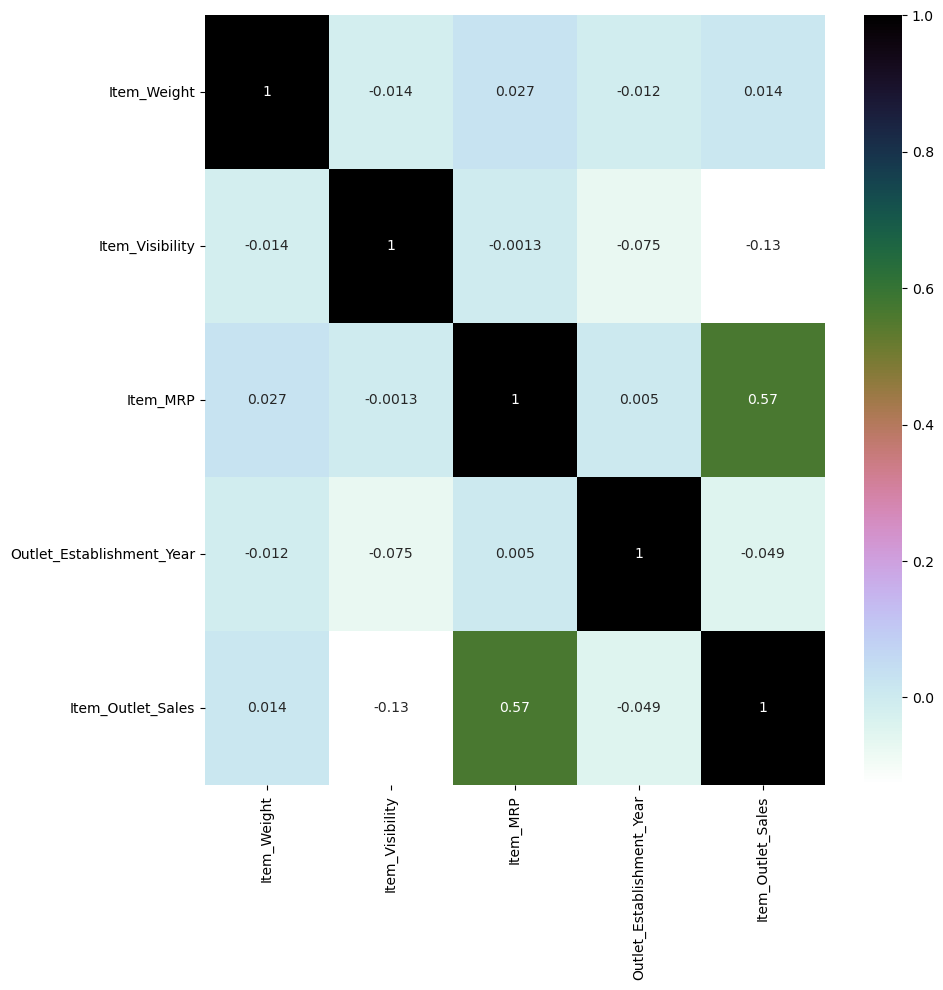

In [59]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(), annot=True, cmap='cubehelix_r')
plt.show()

## Exploratory Data Analysis

We will visualize the data to see the relationship between different variables and and identify the distribution of values in categorical variables.

#### Helper Visualization Functions

In [40]:
def plot_hist(data, column_name, title, xlabel, ylabel):
    plt.title(title)
    data[column_name].hist()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(False)
    plt.show()

In [50]:
def plot_hist_horizontal(data, column_name, title, xlabel, ylabel):
    plt.title(title)
    data[column_name].value_counts().plot(kind='barh')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(False)
    plt.show()

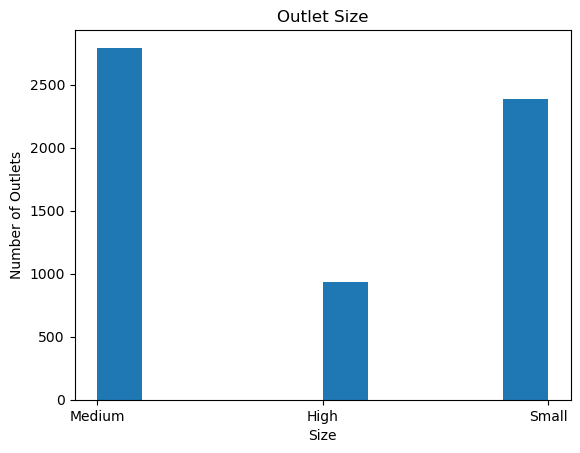

In [41]:
plot_hist(train_data, 'Outlet_Size', 'Outlet Size', 'Size', 'Number of Outlets')

From above we can see that number of outlets with size High is the smallest, small and medium outlets are almost equal in number.

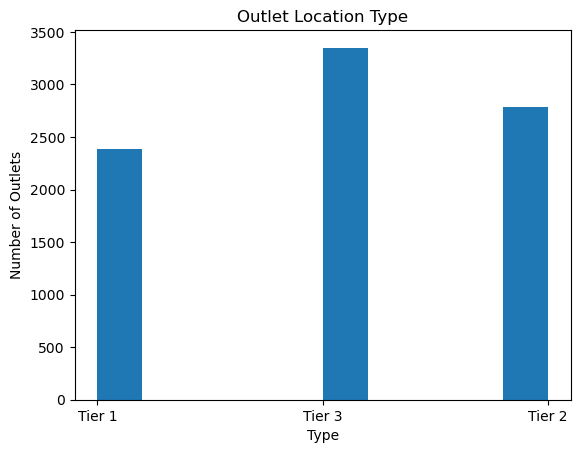

In [42]:
plot_hist(train_data, 'Outlet_Location_Type', 'Outlet Location Type', 'Type', 'Number of Outlets')

From the above plot, we can see that most of items are sell in outlets that are located in Tier 3.

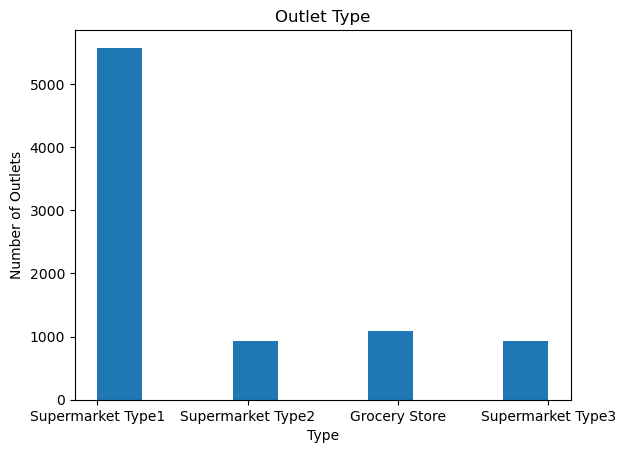

In [44]:
plot_hist(train_data, 'Outlet_Type', 'Outlet Type', 'Type', 'Number of Outlets')

From above plot, we can see that most of outlets exist are from type Supermarket Type1.

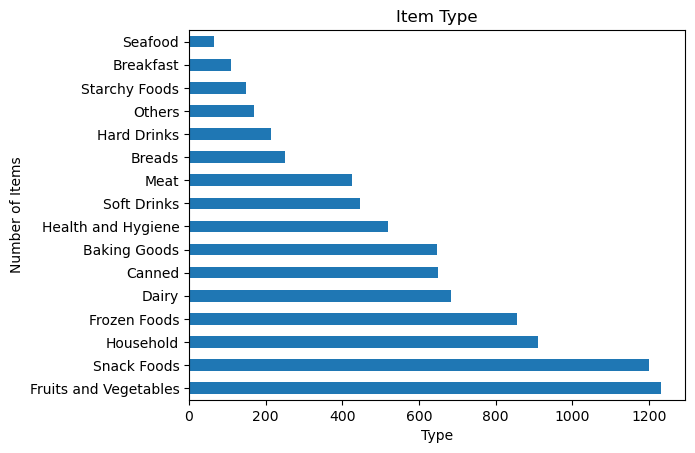

In [52]:
plot_hist_horizontal(train_data, 'Item_Type', 'Item Type', 'Type', 'Number of Items')

From the above plot, we can see that most of items are sell in outlets are snack foods, fruits and vegetables.

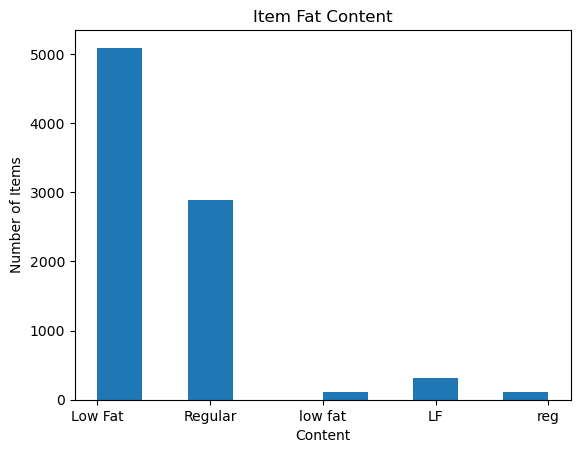

In [54]:
plot_hist(train_data, "Item_Fat_Content", "Item Fat Content", "Content", "Number of Items")

From the above plot, we can see that the Fat Content of most of items are low Fat and Regular.